# Preparation

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
directory = r'C:\Users\DELL\OneDrive\เดสก์ท็อป\King Power'
os.chdir(directory)
print(os.getcwd())

C:\Users\DELL\OneDrive\เดสก์ท็อป\King Power


In [4]:
#read file
data = pd.read_csv('telco.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
Region              7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null

All features have 7,043 non-null object/numeric value, so there is no missing value in data. But the type of "Total Charges" column is object instead of numeric type, so we convert this column to numeric type.

Note : "SeniorCitizen" can be either object or number because there're only 2 values (0,1).

In [5]:
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors='coerce')

In [6]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


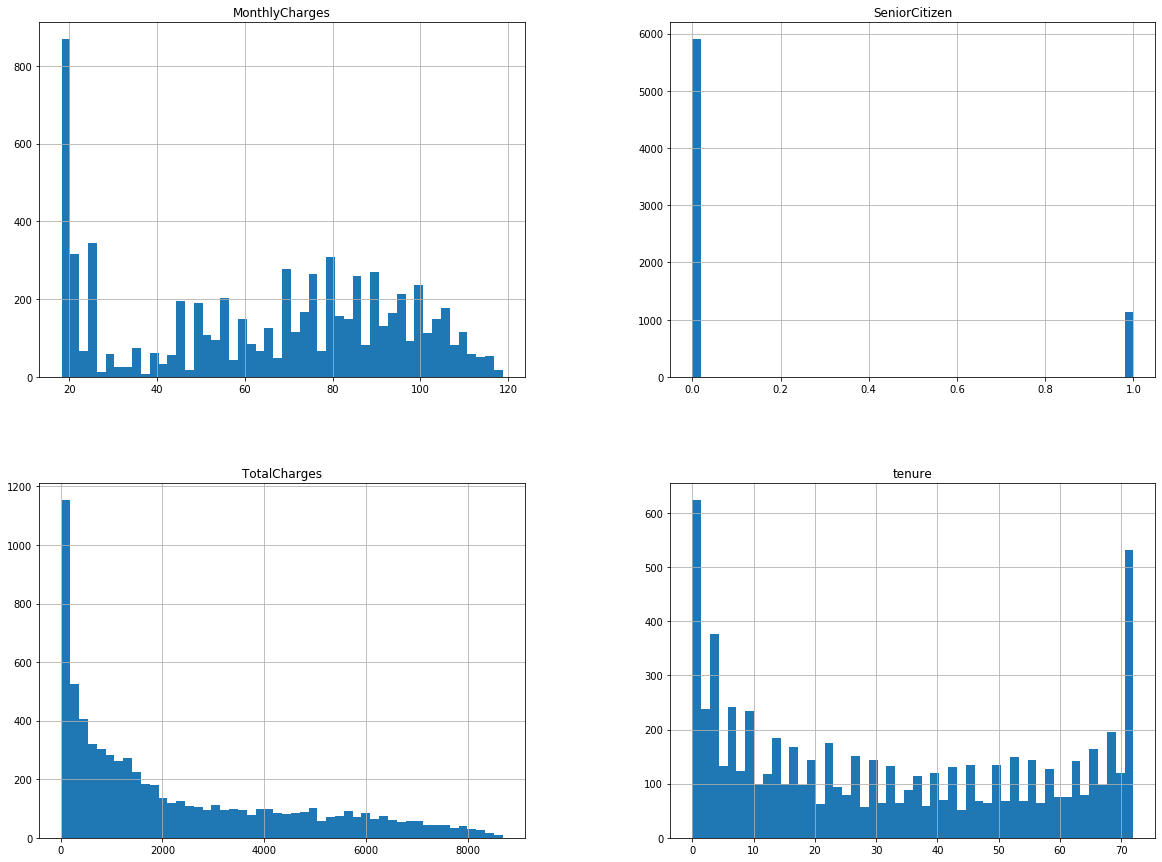

In [7]:
data.hist(bins=50,figsize = (20,15))
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=42)

Split data in train and test set

In [9]:
x_train = train.drop("Churn", axis=1)
y_train = train["Churn"].copy()

x_test = test.drop("Churn", axis=1)
y_test = test["Churn"].copy()



Divide train/test data into x(features) and y(target)

# Data Transformation

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
encoder = OneHotEncoder()
imputer = Imputer(strategy="median")

Preparing for data transformation process which includes
    - StandardScaler for standardization
    - Imputer for dealing with null value
    - OneHotEncoder for categorical features transformation
    - DataFrameSelector for selecting type of features in dataframe

In [11]:
train_num = x_train.select_dtypes(include = ['int64','float64'])
train_cat = x_train.select_dtypes(exclude = ['int64','float64']).drop(['customerID'],axis=1)

Split numeric features and object features and put into train_num and train_cat respectively

In [12]:
from sklearn.pipeline import FeatureUnion
num_attribs = list(train_num)
cat_attribs = list(train_cat)
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_onehot', OneHotEncoder()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ])

Creating pipeline for data transformation (numeric and catagorical features) and merging them together

In [13]:
x_train_prepared = full_pipeline.fit_transform(x_train)
x_test_prepared = full_pipeline.fit_transform(x_test)

Transform data in train and test datasets

In [14]:
y_train = (y_train == 'Yes')
y_test = (y_test == 'Yes')

Convert y (target) to boolean value

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_prepared, y_train)
train_pred = lr.predict(x_train_prepared)
test_pred = lr.predict(x_test_prepared)

Train model by using logistic regression and predict the test dataset

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(lr, x_train_prepared, y_train, cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In this case, we want to save customers as many as possible, so we need high recall and acceptable precision. So we try to find the threshold of scores to define which customer has a chance to churn.

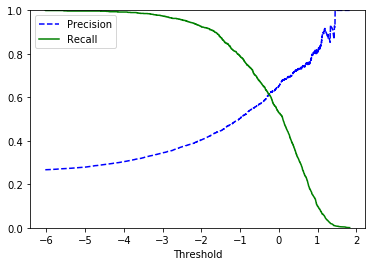

In [17]:
from sklearn.metrics import precision_score, recall_score
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


Let say we want recall at 80% and precision at 50% which is acceptable. So the score threshold is around -1

In [18]:

y_train_pred_70 = (y_scores>-1)
print('precision = ',precision_score(y_train, y_train_pred_70))
print('recall = ',recall_score(y_train, y_train_pred_70))

precision =  0.5032035485460818
recall =  0.7884169884169884


Check if the recall and precision has the value as expected.

In [19]:
y_test_scores = cross_val_predict(lr, x_test_prepared, y_test, cv=3,method="decision_function")
precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, y_test_scores)
y_test_pred_70 = (y_test_scores>-1)
print('precision = ',precision_score(y_test, y_test_pred_70))
print('recall = ',recall_score(y_test, y_test_pred_70))

precision =  0.5454545454545454
recall =  0.8048780487804879


Check if it works for the test dataset too.

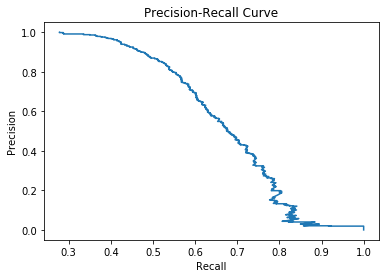

AUC =  0.6668814426055364


In [20]:
from sklearn.metrics import auc
plt.plot(precisions_test,recalls_test)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

pr_auc = auc(recalls_test,precisions_test)
print("AUC = ",pr_auc)

Plot PR-Curve for test dataset